# Introduction

### Competition: [Titanic Kaggle](https://www.kaggle.com/c/titanic/overview)

This is notebook contains a simple data science project framework, for learning and portfolio construction purposes.

# Libs

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.pipeline import Pipeline

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Embedding,  Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

from tensorflow.data import Dataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import QuantileTransformer,  KBinsDiscretizer, StandardScaler
from tensorflow import keras
from sklearn import metrics
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV, cross_val_score

import matplotlib.pyplot as plt

import optuna

# Load Dataset

This step we simply get our data to our working environment. Because we are not dealing with live data, a simple pandas usage is enough.

In [2]:
%%time

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

Wall time: 13 ms


# Preprocessing

In [3]:
%%time

train['Survived'] = train['Survived'].astype(str)

train['n_missing'] = train.isna().sum(axis=1)
test['n_missing'] = test.isna().sum(axis=1)

test['Pclass']= test['Pclass'].astype(str)
test['Pclass']= test['Pclass'].astype(str)

features = [col for col in train.columns if col not in ['Survived', 'PassengerId']]

Wall time: 5.99 ms


### *Name* Column 

In [4]:
print(len(train['Name'].unique()))
print(train['Name'].unique()[0:5])

891
['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry']


**With the *Name* column the way it is, we can't use it in our models.** The reason is because as every person has a unique name, then the name has no information about our variable of interest (*Survived*).

One thing we can see in this column is the presence of titles. **We can probably assume different survival rates when considering different titles.**

In [5]:
name_and_title = [name.split(", ")[1] for name in train['Name']]
title = [name.split(".")[0] for name in name_and_title]
print(len(title))

891


In [6]:
print(len(np.unique(title)))
np.unique(title)

17


array(['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master',
       'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir',
       'the Countess'], dtype='<U12')

In [7]:
train['Name'] = title
test['Name'] = [name.split(".")[0] for name in [name.split(", ")[1] for name in test['Name']]] 

In [8]:
train = pd.concat([train, pd.get_dummies(train['Name']).filter(['Miss', 'Mr', 'Mrs', 'Ms'])], axis = 1)
train.drop('Name', axis = 1, inplace = True)

test = pd.concat([test, pd.get_dummies(test['Name']).filter(['Miss', 'Mr', 'Mrs', 'Ms'])], axis = 1)
test.drop('Name', axis = 1, inplace = True)

### Dealing with the Ticket feature

In [9]:
train['Ticket'][0:5]

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

**One hypothesis we can make** is that the numbers don't contain any relevant information and the prefix may contain relevant information.

In [10]:
ticket_prefixes = [ticket.split()[0] for ticket in train['Ticket']]
ticket_prefixes[0:5]

['A/5', 'PC', 'STON/O2.', '113803', '373450']

In [11]:
for i in range(len(ticket_prefixes)):
    try: 
        int(ticket_prefixes[i])
        ticket_prefixes[i] = "number_only"
    
    except Exception:
        pass

In [12]:
ticket_prefixes[0:5]

['A/5', 'PC', 'STON/O2.', 'number_only', 'number_only']

In [13]:
print(len(np.unique(ticket_prefixes)))
np.unique(ticket_prefixes)

44


array(['A./5.', 'A.5.', 'A/4', 'A/4.', 'A/5', 'A/5.', 'A/S', 'A4.', 'C',
       'C.A.', 'C.A./SOTON', 'CA', 'CA.', 'F.C.', 'F.C.C.', 'Fa', 'LINE',
       'P/PP', 'PC', 'PP', 'S.C./A.4.', 'S.C./PARIS', 'S.O./P.P.',
       'S.O.C.', 'S.O.P.', 'S.P.', 'S.W./PP', 'SC', 'SC/AH', 'SC/PARIS',
       'SC/Paris', 'SCO/W', 'SO/C', 'SOTON/O.Q.', 'SOTON/O2', 'SOTON/OQ',
       'STON/O', 'STON/O2.', 'SW/PP', 'W./C.', 'W.E.P.', 'W/C', 'WE/P',
       'number_only'], dtype='<U11')

In [14]:
ticket_prefixes = [s.replace(".", "") for s in ticket_prefixes]
ticket_prefixes = [s.replace(",", "") for s in ticket_prefixes]
ticket_prefixes = [s.upper() for s in ticket_prefixes]

In [15]:
print(len(np.unique(ticket_prefixes)))
np.unique(ticket_prefixes)

34


array(['A/4', 'A/5', 'A/S', 'A4', 'A5', 'C', 'CA', 'CA/SOTON', 'FA', 'FC',
       'FCC', 'LINE', 'NUMBER_ONLY', 'P/PP', 'PC', 'PP', 'SC', 'SC/A4',
       'SC/AH', 'SC/PARIS', 'SCO/W', 'SO/C', 'SO/PP', 'SOC', 'SOP',
       'SOTON/O2', 'SOTON/OQ', 'SP', 'STON/O', 'STON/O2', 'SW/PP', 'W/C',
       'WE/P', 'WEP'], dtype='<U11')

In [16]:
test_ticket_prefixes = [ticket.split()[0] for ticket in test['Ticket']]
for i in range(len(test_ticket_prefixes)):
    try: 
        int(test_ticket_prefixes[i])
        test_ticket_prefixes[i] = "number_only"
    
    except Exception:
        pass

test_ticket_prefixes = [s.replace(".", "") for s in test_ticket_prefixes]
test_ticket_prefixes = [s.replace(",", "") for s in test_ticket_prefixes]
test_ticket_prefixes = [s.upper() for s in test_ticket_prefixes]

In [17]:
train['Ticket'] = ticket_prefixes
test['Ticket'] = test_ticket_prefixes

In [18]:
train = pd.concat([train, pd.get_dummies(train['Ticket']).filter(['PC', 'CA', 'NUMBER_ONLY'])], axis = 1)
train.drop('Ticket', axis = 1, inplace = True)

test = pd.concat([test, pd.get_dummies(test['Ticket']).filter(['PC', 'CA', 'NUMBER_ONLY'])], axis = 1)
test.drop('Ticket', axis = 1, inplace = True)

### Dealing with the Cabin feature

Same as the *Ticket* feature. I will assume that the number doesn't have relevant information.

In [19]:
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [20]:
cabin_prefix = []
for i in range(len(train['Cabin'])):
    try:
        cabin_prefix.append(train['Cabin'][i][0: 1: 1])
    
    except:
        cabin_prefix.append(train['Cabin'][i])        

In [21]:
np.unique(cabin_prefix)

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'nan'], dtype='<U32')

In [22]:
cabin_test_prefix = []
for i in range(len(test['Cabin'])):
    try:
        cabin_test_prefix.append(test['Cabin'][i][0: 1: 1])
    
    except:
        cabin_test_prefix.append(test['Cabin'][i])

In [23]:
train['Cabin'] = cabin_prefix
test['Cabin'] = cabin_test_prefix

In [24]:
train = pd.concat([train, pd.get_dummies(train['Cabin']).filter(['NaN', 'B', 'C'])], axis = 1)
train.drop('Cabin', axis = 1, inplace = True)

test = pd.concat([test, pd.get_dummies(test['Cabin']).filter(['NaN', 'B', 'C'])], axis = 1)
test.drop('Cabin', axis = 1, inplace = True)

## Pclass, Sex and Embarked variables

In [25]:
train = pd.get_dummies(train, columns = ['Pclass', 'Sex', 'Embarked'])
test = pd.get_dummies(test, columns = ['Pclass', 'Sex', 'Embarked'])

## Imputer and Scaler

In [26]:
%%time

features = [col for col in train.columns if col not in ['Survived', 'PassengerId']]
numerical_features = [col for col in features if col in ['Age', 'SibSp', 'Parch', 'Fare', 'n_missing']]

pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean',missing_values=np.nan)),
        ("scaler", StandardScaler())
        ])

train[numerical_features] = pipe.fit_transform(train[numerical_features])
test[numerical_features] = pipe.transform(test[numerical_features])

train['Survived'] = train['Survived'].astype(int)

Wall time: 12 ms


# Clustering variable

In [28]:
from sklearn.cluster import KMeans, DBSCAN

best_k = float('inf')

inertia_values = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters = k, n_init = 100, max_iter = 500, copy_x = False)
    kmeans.fit(train[features])
    
    if k < best_k:
        best_k = k
    
    inertia_values.append(kmeans.inertia_)
    print("k: ", k , " Inertia: ", kmeans.inertia_)

k:  2  Inertia:  5466.229288766526
k:  3  Inertia:  4521.282674654894
k:  4  Inertia:  4076.124018557896
k:  5  Inertia:  3711.1016161599805
k:  6  Inertia:  3373.365556425289
k:  7  Inertia:  3126.372478806292
k:  8  Inertia:  2928.3450623741946
k:  9  Inertia:  2758.049769098987
k:  10  Inertia:  2637.054074317592
k:  11  Inertia:  2514.2071347717088
k:  12  Inertia:  2401.2740571488903
k:  13  Inertia:  2306.8478962346035
k:  14  Inertia:  2195.715024063293
k:  15  Inertia:  2115.784425542569
k:  16  Inertia:  2042.9573650967284
k:  17  Inertia:  1982.4949209182926
k:  18  Inertia:  1921.5089443552351
k:  19  Inertia:  1872.4848585401296


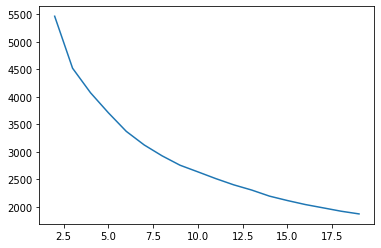

In [30]:
plt.plot(range(2, 20), inertia_values); # K = 3

In [31]:
kmeans = KMeans(n_clusters = 3, n_init = 100, max_iter = 500, copy_x = False)
kmeans.fit_transform(train[features])

array([[3.25188637, 1.45776238, 2.88542032],
       [2.03421164, 3.75795147, 4.20923063],
       [3.18355936, 1.89172458, 3.16197695],
       ...,
       [4.46843718, 3.34706176, 2.42696312],
       [2.24994573, 2.87117162, 4.07855735],
       [3.14494331, 1.41225138, 3.59888404]])

In [42]:
kmeans = KMeans(n_clusters = 3, n_init = 100, max_iter = 500, copy_x = False)
kmeans.fit_transform(train[features])
train[['cluster_0', 'cluster_1', 'cluster_2']] =  pd.get_dummies(kmeans.labels_)

kmeans.transform(test[features])
test[['cluster_0', 'cluster_1', 'cluster_2']] =  pd.get_dummies(kmeans.predict(test[features]))

features = [col for col in train.columns if col not in ['Survived', 'PassengerId']]

# Base Models

## Light GBM

In [44]:
import lightgbm as lgb

def objective(trial):
    
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 32),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    kf = KFold(5, shuffle = True, random_state = 0)
    kf.split(train)
    
    accuracy_scores = []
    
    for train_ix, test_ix in kf.split(train):
        dtrain = lgb.Dataset(train[features].iloc[train_ix,:], label = train['Survived'].iloc[train_ix])
        
        gbm = lgb.train(param, dtrain)
        preds = np.rint(gbm.predict(train[features].iloc[test_ix]))
        
        accuracy_scores.append(metrics.accuracy_score(train['Survived'].iloc[test_ix], preds))
        
    return np.mean(accuracy_scores)
    

# # 3. Create a study object and optimize the objective function.
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=250)

In [ ]:
'''
{'lambda_l1': 5.5693205859882666e-08,
 'lambda_l2': 0.0029379573632802307,
 'num_leaves': 218,
 'feature_fraction': 0.4449630393801182,
 'bagging_fraction': 0.6190711470746258,
 'bagging_freq': 1,
 'min_child_samples': 24}
'''

In [49]:
kf_stacking = KFold(4, shuffle = True, random_state = 0)
kf_stacking.split(train)

for train_ix, test_ix in kf_stacking.split(train):
    lgbm = lgb.train(
        {'lambda_l1': 5.5693205859882666e-08,
         'lambda_l2': 0.0029379573632802307,
         'num_leaves': 218,
         'feature_fraction': 0.4449630393801182,
         'bagging_fraction': 0.6190711470746258,
         'bagging_freq': 1,
         'min_child_samples': 24}, 
        lgb.Dataset(train[features].iloc[train_ix,:], label = train['Survived'].iloc[train_ix]))
    
    train['lv1_lgbm_preds'].iloc[test_ix] = lgbm.predict(train[features].iloc[test_ix])
    
lgbm.fit(train[features], train['Survived'])
test['lv1_lgbm_preds'] = lgbm.predict(test[features])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 668, number of used features: 21
[LightGBM] [Info] Start training from score 0.386228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## Grandient Boosting Machine

In [51]:
from sklearn.ensemble import GradientBoostingClassifier 

def objective(trial):
    
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-2)
    n_estimators = trial.suggest_int('n_estimators', 20, 200)
    subsample = trial.suggest_float('subsample', 0.75, 1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.75, 1)
    max_features = trial.suggest_int('max_features', 3, 20)
    
    gbm = GradientBoostingClassifier(learning_rate = learning_rate,
                                     n_estimators = n_estimators,
                                     subsample = subsample,
                                     min_samples_split = min_samples_split,
                                     min_samples_leaf = min_samples_leaf,
                                     max_depth = max_depth,
                                     min_impurity_decrease = min_impurity_decrease,
                                     random_state = 42,
                                     max_features = max_features)
    
    kf = KFold(5, shuffle = True, random_state = 0)
    kf.split(train)
    
    accuracy_scores = []
    
    for train_ix, test_ix in kf.split(train):
        gbm.fit(train[features].iloc[train_ix,:], train['Survived'].iloc[train_ix])
        preds = np.rint(gbm.predict(train[features].iloc[test_ix]))
        
        accuracy_scores.append(metrics.accuracy_score(train['Survived'].iloc[test_ix], preds))
        
    return np.mean(accuracy_scores)
    

# 3. Create a study object and optimize the objective function.
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=1000)

In [ ]:
'''
learning_rate = 0.009620110160365543,
n_estimators = 135,
subsample = 0.9699332268604093,
min_samples_split = 12,
min_samples_leaf = 2,
max_depth = 7,
min_impurity_decrease = 0.7763728807219239,
max_features = 20
'''

In [52]:
kf_stacking = KFold(4, shuffle = True, random_state = 0)
kf_stacking.split(train)

for train_ix, test_ix in kf_stacking.split(train):
    gbm = GradientBoostingClassifier(
        learning_rate = 0.009620110160365543,
        n_estimators = 135,
        subsample = 0.9699332268604093,
        min_samples_split = 12,
        min_samples_leaf = 2,
        max_depth = 7,
        min_impurity_decrease = 0.7763728807219239,
        max_features = 20,
        random_state = 42)
    
    gbm.fit(train[features].iloc[train_ix], train['Survived'].iloc[train_ix])
    train['lv1_gbm_preds'].iloc[test_ix] = gbm.predict(train[features].iloc[test_ix])    
    
gbm.fit(train[features], train['Survived'])
test['lv1_gbm_preds'] = gbm.predict(test[features])

## SVM

In [44]:
from sklearn.svm import SVC

def objective(trial):
    
    svc = SVC(C = trial.suggest_float('C', 1e-6, 10))
    
    kf = KFold(5, shuffle = True, random_state = 0)
    kf.split(train)
    
    accuracy_scores = []
    
    for train_ix, test_ix in kf.split(train):
        svc.fit(train[features].iloc[train_ix,:], train['Survived'].iloc[train_ix])
        preds = svc.predict(train[features].iloc[test_ix])
        
        accuracy_scores.append(metrics.accuracy_score(train['Survived'].iloc[test_ix], preds))
        
    return np.mean(accuracy_scores)
    

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2021-12-22 17:32:25,401] A new study created in memory with name: no-name-1b4e1f78-78ca-475b-aee3-0355ad45723f
[I 2021-12-22 17:32:25,554] Trial 0 finished with value: 0.8137028435126483 and parameters: {'C': 2.7032851136834055}. Best is trial 0 with value: 0.8137028435126483.
[I 2021-12-22 17:32:25,709] Trial 1 finished with value: 0.8024606113866047 and parameters: {'C': 9.842259051972448}. Best is trial 0 with value: 0.8137028435126483.
[I 2021-12-22 17:32:25,851] Trial 2 finished with value: 0.8114493754315486 and parameters: {'C': 2.0593502553051386}. Best is trial 0 with value: 0.8137028435126483.
[I 2021-12-22 17:32:25,999] Trial 3 finished with value: 0.812560416797439 and parameters: {'C': 4.747764754496287}. Best is trial 0 with value: 0.8137028435126483.
[I 2021-12-22 17:32:26,156] Trial 4 finished with value: 0.8002196974452327 and parameters: {'C': 9.984978618163364}. Best is trial 0 with value: 0.8137028435126483.
[I 2021-12-22 17:32:26,302] Trial 5 finished with value

[I 2021-12-22 17:32:32,732] Trial 45 finished with value: 0.8249262444291006 and parameters: {'C': 0.355871282628188}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:32,879] Trial 46 finished with value: 0.8103383340656581 and parameters: {'C': 1.6021071714032882}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:33,034] Trial 47 finished with value: 0.8249262444291006 and parameters: {'C': 0.35345209996611704}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:33,223] Trial 48 finished with value: 0.6161634548992531 and parameters: {'C': 0.00022276528764630932}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:33,374] Trial 49 finished with value: 0.8114430983616847 and parameters: {'C': 4.267226387649706}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:33,527] Trial 50 finished with value: 0.8058251208335948 and parameters: {'C': 6.120269520056619}. Best is trial 42 with value: 0.82

[I 2021-12-22 17:32:39,758] Trial 91 finished with value: 0.8282970309459545 and parameters: {'C': 0.5084084209077346}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:39,918] Trial 92 finished with value: 0.8204318624066286 and parameters: {'C': 0.18408919243029925}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:40,066] Trial 93 finished with value: 0.8260498399347185 and parameters: {'C': 0.5616279243647636}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:40,212] Trial 94 finished with value: 0.8181846713953925 and parameters: {'C': 1.1469399586625986}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:40,379] Trial 95 finished with value: 0.8204255853367648 and parameters: {'C': 0.12827151377307267}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:40,524] Trial 96 finished with value: 0.8215554579122465 and parameters: {'C': 0.7287191137585587}. Best is trial 42 with value: 0.82

[I 2021-12-22 17:32:46,595] Trial 136 finished with value: 0.8260498399347185 and parameters: {'C': 0.4024839803781737}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:46,786] Trial 137 finished with value: 0.6161634548992531 and parameters: {'C': 0.0014738067632984464}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:46,932] Trial 138 finished with value: 0.8159374803841567 and parameters: {'C': 1.2081690908851908}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:47,079] Trial 139 finished with value: 0.8181846713953925 and parameters: {'C': 0.9611024927149677}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:47,227] Trial 140 finished with value: 0.8271734354403364 and parameters: {'C': 0.5291537916111546}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:47,378] Trial 141 finished with value: 0.8282970309459545 and parameters: {'C': 0.44070883974888253}. Best is trial 42 with val

[I 2021-12-22 17:32:53,461] Trial 181 finished with value: 0.8271734354403364 and parameters: {'C': 0.5479483735273605}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:53,607] Trial 182 finished with value: 0.8249262444291003 and parameters: {'C': 0.6298755591995827}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:53,752] Trial 183 finished with value: 0.8226790534178645 and parameters: {'C': 0.8812676629844802}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:53,902] Trial 184 finished with value: 0.8271734354403364 and parameters: {'C': 0.41491203374440466}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:54,051] Trial 185 finished with value: 0.8282970309459545 and parameters: {'C': 0.463402767240481}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:32:54,214] Trial 186 finished with value: 0.8204318624066286 and parameters: {'C': 0.1614129555949554}. Best is trial 42 with value: 

[I 2021-12-22 17:33:01,180] Trial 226 finished with value: 0.8282970309459545 and parameters: {'C': 0.514213109462163}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:01,342] Trial 227 finished with value: 0.8204318624066286 and parameters: {'C': 0.1725634166882783}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:01,493] Trial 228 finished with value: 0.8249199673592367 and parameters: {'C': 0.3171882721089322}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:01,642] Trial 229 finished with value: 0.8282970309459545 and parameters: {'C': 0.4947869220702496}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:01,789] Trial 230 finished with value: 0.8226790534178645 and parameters: {'C': 0.8750346080864709}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:01,935] Trial 231 finished with value: 0.8238026489234824 and parameters: {'C': 0.6241072331933136}. Best is trial 42 with value: 0

[I 2021-12-22 17:33:08,032] Trial 271 finished with value: 0.8215491808423827 and parameters: {'C': 0.23382421557782065}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:08,179] Trial 272 finished with value: 0.8170610758897746 and parameters: {'C': 1.1598675385129842}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:08,326] Trial 273 finished with value: 0.8249262444291006 and parameters: {'C': 0.6168837997785778}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:08,476] Trial 274 finished with value: 0.8260498399347185 and parameters: {'C': 0.37850097340908273}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:08,622] Trial 275 finished with value: 0.8226790534178645 and parameters: {'C': 0.8875667134612758}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:08,769] Trial 276 finished with value: 0.8260498399347185 and parameters: {'C': 0.5655775372799079}. Best is trial 42 with value

[I 2021-12-22 17:33:14,911] Trial 316 finished with value: 0.8204255853367648 and parameters: {'C': 0.10433536546232997}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:15,059] Trial 317 finished with value: 0.8226790534178645 and parameters: {'C': 0.7923369847248019}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:15,207] Trial 318 finished with value: 0.8137028435126483 and parameters: {'C': 2.600752248965409}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:15,362] Trial 319 finished with value: 0.8226727763480008 and parameters: {'C': 0.24131644576652278}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:15,508] Trial 320 finished with value: 0.8170610758897746 and parameters: {'C': 1.1549614027205135}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:15,662] Trial 321 finished with value: 0.8282970309459545 and parameters: {'C': 0.4447589622490745}. Best is trial 42 with value:

[I 2021-12-22 17:33:21,777] Trial 361 finished with value: 0.8204255853367648 and parameters: {'C': 0.12516235926623503}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:21,936] Trial 362 finished with value: 0.803577929822359 and parameters: {'C': 8.685231070425681}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:22,094] Trial 363 finished with value: 0.8238026489234824 and parameters: {'C': 0.3412728486628521}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:22,241] Trial 364 finished with value: 0.8238026489234824 and parameters: {'C': 0.6726734078288742}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:22,387] Trial 365 finished with value: 0.8238026489234824 and parameters: {'C': 0.6552086852283692}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:22,535] Trial 366 finished with value: 0.8170610758897746 and parameters: {'C': 0.9930298945887728}. Best is trial 42 with value: 0

[I 2021-12-22 17:33:28,757] Trial 406 finished with value: 0.8148138848785387 and parameters: {'C': 1.2143391905358243}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:28,910] Trial 407 finished with value: 0.8282970309459545 and parameters: {'C': 0.5012676762957576}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:29,061] Trial 408 finished with value: 0.8260498399347185 and parameters: {'C': 0.5568105151165078}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:29,220] Trial 409 finished with value: 0.8215491808423827 and parameters: {'C': 0.22806842312586736}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:29,368] Trial 410 finished with value: 0.8215554579122465 and parameters: {'C': 0.7365295849645037}. Best is trial 42 with value: 0.8282970309459545.
[I 2021-12-22 17:33:29,528] Trial 411 finished with value: 0.8204318624066286 and parameters: {'C': 0.1972338895059774}. Best is trial 42 with value:

KeyboardInterrupt: 

In [ ]:
'''
C = 0.4898842008006796
'''

In [47]:
kf_stacking = KFold(4, shuffle = True, random_state = 0)
kf_stacking.split(train)

lv1_svc_preds = train['PassengerId'].copy()

for train_ix, test_ix in kf_stacking.split(train):
    svc = SVC(C = 0.4898842008006796)
    
    svc.fit(train[features].iloc[train_ix], train['Survived'].iloc[train_ix])
    lv1_svc_preds.iloc[test_ix] = svc.predict(train[features].iloc[test_ix])
    
svc.fit(train[features], train['Survived'])
test['lv1_svc_preds'] = svc.predict(test[features])

## Random Forest

In [74]:
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    
    rf = RandomForestClassifier(
        n_estimators = trial.suggest_int('n_estimators', 10, 250),
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']),
        max_depth = trial.suggest_int('max_depth', 3, 12),
        min_samples_split = trial.suggest_int('min_samples_split', 0, 100),
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 0, 25), 
        max_features = trial.suggest_int('max_features', 1, 25),
        max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 200),
        random_state = 0
    )
    
    
    kf = KFold(5, shuffle = True, random_state = 0)
    kf.split(train)
    
    accuracy_scores = []
    
    for train_ix, test_ix in kf.split(train):
        rf.fit(train[features].iloc[train_ix,:], train['Survived'].iloc[train_ix])
        preds = rf.predict(train[features].iloc[test_ix])
        
        accuracy_scores.append(metrics.accuracy_score(train['Survived'].iloc[test_ix], preds))
        
    return np.mean(accuracy_scores)
    

# 3. Create a study object and optimize the objective function.

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2021-12-22 18:40:08,773] A new study created in memory with name: no-name-81649dcd-bc7b-49dc-b3d3-f5da5ffd3906
[I 2021-12-22 18:40:09,507] Trial 0 finished with value: 0.8136902893729208 and parameters: {'n_estimators': 99, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 7, 'max_leaf_nodes': 138}. Best is trial 0 with value: 0.8136902893729208.
[I 2021-12-22 18:40:10,886] Trial 1 finished with value: 0.793496955621116 and parameters: {'n_estimators': 167, 'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 90, 'min_samples_leaf': 24, 'max_features': 25, 'max_leaf_nodes': 189}. Best is trial 0 with value: 0.8136902893729208.
[I 2021-12-22 18:40:11,248] Trial 2 finished with value: 0.8024919967359236 and parameters: {'n_estimators': 42, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 63, 'min_samples_leaf': 10, 'max_features': 21, 'max_leaf_nodes': 98}. Best is trial 0 with value: 0.8136902893729208.
[I 2021-12-22

ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
logit = LogisticRegression()

cv = cross_validate(logit, pd.concat(
    [lv1_gbm_preds, lv1_lgbm_preds, lv1_svc_preds], axis = 1), train['Survived'], scoring = "accuracy", cv = 3)

In [54]:
cv['test_score'].mean()

0.8294051627384961

In [63]:
submission = pd.read_csv('data/submission.csv')

In [97]:
submission['Survived'] = np.abs(np.rint(preds))

In [98]:
submission.to_csv("data/submission.csv", index = False)

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0
...,...,...
413,1305,0.0
414,1306,1.0
415,1307,0.0
416,1308,0.0


In [65]:
lgbm = lgb.train({
    'lambda_l1': 3.0382509030081943e-07,
    'lambda_l2': 1.7528164440749284e-06,
    'num_leaves': 28,
    'feature_fraction': 0.7757503939389271,
    'bagging_fraction': 0.6778524391467955,
    'bagging_freq': 1,
    'min_child_samples': 42}, 
    lgb.Dataset(train[features], label = train['Survived']))

submission['Survived'] =  np.abs(np.rint(lgbm.predict(test[features])))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 23
[LightGBM] [Info] Start training from score 0.383838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [67]:
submission.to_csv("data/submission.csv", index = False)

In [68]:
submission

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0
...,...,...
413,1305,0.0
414,1306,1.0
415,1307,0.0
416,1308,0.0
